In [8]:
# Import useful things

import numpy as np      
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib import rcParams
import matplotlib.dates as md
import os
import glob
import sys
sys.path.append('/Users/heather/ICECAPS-ACE/DataParse/')

from ace_parse import *
from utils import * 

# Plotting preferences:
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams.update({'font.size': 16}) 
rcParams['axes.titlepad'] = 16 
rcParams['xtick.major.pad']='12'
rcParams['ytick.major.pad']='12'

# Supress warnings for notebook ease of use
import warnings
warnings.filterwarnings("ignore")

In [10]:
# Merge all the hourly netcdfs for that day. 
import netCDF4
from netCDF4 import Dataset

# MMCR data location
dloc = '/Volumes/Data/ICECAPSarchive/Nephelometer/'

# Date of interest
start = dt.datetime(2019,1,1,0)
stop = dt.datetime(2019,12,31,23)

year1 = start.year
year2 = stop.year
all_files = []

floc1 = dloc + 'ESRL-GMD-AEROSOL_v1.0_HOUR_SUM_s%s0101T000000Z_e%s0101T000000Z'%(year1,year1)
os.chdir(dloc)                  # Change directory to where the data is
all_files.append(glob.glob(dloc + 'ESRL-GMD-AEROSOL_v1.0_HOUR_SUM_s%s0101T000000Z_e%s0101T000000Z*'%(year1,year1+1)))
if year1 != year2: 
    all_files.append(glob.glob(dloc + 'ESRL-GMD-AEROSOL_v1.0_HOUR_SUM_s%s0101T000000Z_e%s0101T000000Z*'%(year2,year2+1)))

flatten = lambda l: [item for sublist in l for item in sublist]
all_files = flatten(all_files)
all_files.sort()

if len(all_files)>1:
    nc = netCDF4.MFDataset(all_files,'r')
else:
    nc = netCDF4.Dataset(all_files[0],'r')

In [14]:

time_raw = nc.groups['data'].variables['time']
time = netCDF4.num2date(time_raw[:],time_raw.units)

# Absorption
ab_group = nc.groups['data'].groups['light_absorption']
ab_wavelengths = ab_group.variables['wavelength'][:]      # Central measurement wavelength (nm), 3D
ab_coef = ab_group.variables['absorption_coefficient'][:] # Absorption coefficient at ST (M/m) [wavelength, time]
ab_cutsize = ab_group.variables['cut_size'][:]              # Maximum aerodyamic particle diameter (um), 1D

# Scattering
sc_group = nc.groups['data'].groups['light_scattering']
sc_wavelengths = sc_group.variables['wavelength'][:]      # Central measurement wavelength. 
sc_coef = sc_group.variables['scattering_coefficient'][:]    # Backwards hemispheric scatering coefficent at STP (M/m)
sample_pres = sc_group.variables['sample_pressure'][:]       # %
sample_humid= sc_group.variables['sample_humidity'][:]       # hPa
sample_T= sc_group.variables['sample_temperature'][:]        # degC
sc_cutsize = sc_group.variables['cut_size'][:]            # Maximum aerodyamic particle diameter (um), 1D

# Put in pandas dataframe

sc_df = pd.DataFrame({'Time':time,'sc_1':sc_coef[0,:],'sc_2':sc_coef[1,:],'sc_3':sc_coef[2,:]})
sc_df = sc_df.set_index('Time')
sc_df.index = pd.DatetimeIndex(sc_df.index)

ab_df = pd.DataFrame({'Time':time,'ab_1':ab_coef[0,:],'ab_2':ab_coef[1,:],'ab_3':ab_coef[2,:]})
ab_df = ab_df.set_index('Time')
ab_df.index = pd.DatetimeIndex(ab_df.index)


In [99]:

# QC

# QC for north winds (has to be done before flight dates else risks getting overwritten)
months = pd.date_range(start,stop,freq='1M')
for month in months: 
    print('QCing %s for north winds'%month.strftime(format('%Y-%m')))
    w_dloc = '/Volumes/Data/ICECAPSarchive/Summit_Met/met_sum_insitu_1_obop_minute_%s_%s.txt'%(month.year,str(month.month).zfill(2))
    met = get_NOAA_met(w_dloc)
    met['temp_QC'] = np.ones(len(met))
    met['temp_QC'][met['ws']<1]=0
    met['temp_QC'][met['wd']<72]=0
    met['temp_QC'][met['wd']>342]=0
    temp_qc = met['temp_QC'].resample('1H').min()
    sc_df['QC'].loc[temp_qc.index.strftime(date_format='%Y%m%d%H%M')[0] : temp_qc.index.strftime(date_format='%Y%m%d%H%M')[-1]] = temp_qc
    ab_df['QC'].loc[temp_qc.index.strftime(date_format='%Y%m%d%H%M')[0] : temp_qc.index.strftime(date_format='%Y%m%d%H%M')[-1]] = temp_qc    

sc_df['QC'] = np.ones(len(sc_df))
ab_df['QC'] = np.ones(len(ab_df))

# Get flight dates
flight_dates_f = '/Volumes/Data/ICECAPSarchive/qc_files/flight_days.csv'
flight_times = pd.read_csv(flight_dates_f,parse_dates={'Dates':[0],'ondeckUTC':[0,3],'offdeckUTC':[0,4]})
flight_start = flight_times['ondeckUTC']
flight_stop = flight_times['offdeckUTC']
flight_starts = (pd.to_datetime(flight_start,errors='coerce').dt.round('H') - pd.Timedelta('3H'))
flight_stops = (pd.to_datetime(flight_start,errors='coerce').dt.round('H') + pd.Timedelta('3H'))

print('QCing flight dates')
for i in range(0,len(flight_starts)):
    if (flight_starts[i]!= np.nan) & (flight_stops[i]!=np.nan):       
        sc_df['QC'][(sc_df.index>=flight_starts[i]) & (sc_df.index<=flight_stops[i])] = 0
        ab_df['QC'][(ab_df.index>=flight_starts[i]) & (ab_df.index<=flight_stops[i])] = 0



QCing 2019-01 for north winds
QCing 2019-02 for north winds
QCing 2019-03 for north winds
QCing 2019-04 for north winds
QCing 2019-05 for north winds
QCing 2019-06 for north winds
QCing 2019-07 for north winds
QCing 2019-08 for north winds
QCing 2019-09 for north winds
QCing 2019-10 for north winds
QCing 2019-11 for north winds
QCing 2019-12 for north winds
QCing flight dates


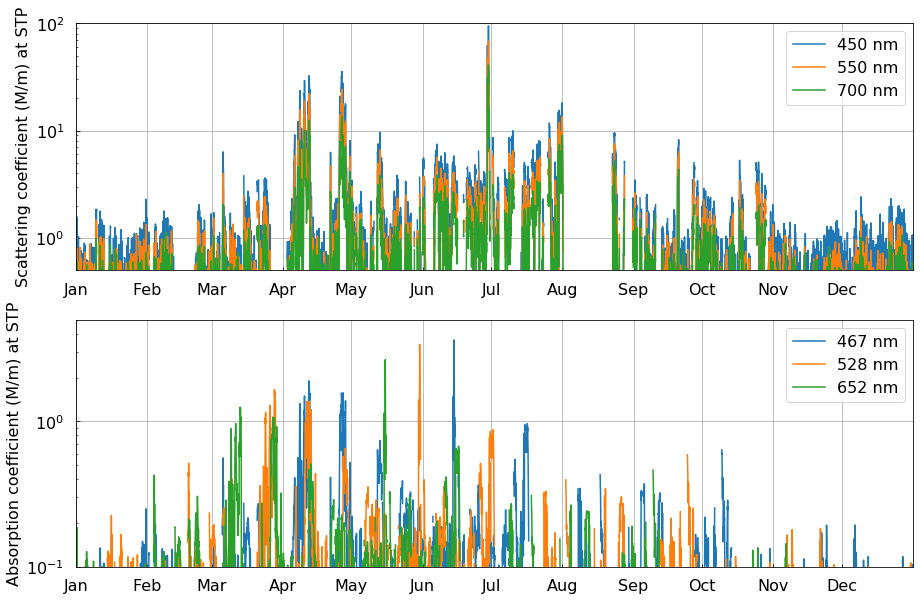

In [104]:

# Plot non-qc'd

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(211)
ax1.plot(sc_df.index,sc_df['sc_1'],label='%s nm'%int(sc_wavelengths[0])) 
ax1.plot(sc_df.index,sc_df['sc_2'],label='%s nm'%int(sc_wavelengths[1])) 
ax1.plot(sc_df.index,sc_df['sc_3'],label='%s nm'%int(sc_wavelengths[2]))
ax1.set_ylabel('Scattering coefficient (M/m) at STP')
ax1.xaxis.set_major_formatter(md.DateFormatter('%H'))
ax1.xaxis.set_major_locator(md.HourLocator(interval=1))
ax1.set_ylim(0.5,100)
ax1.set_yscale('log')
ax1.set_xlim(start,stop)
ax1.grid('on')
ax1.legend()

ax1.xaxis.set_major_formatter(md.DateFormatter('%b'))
ax1.xaxis.set_major_locator(md.DayLocator(bymonthday=1))
#ax1.xaxis.set_major_locator(md.HourLocator(interval=3))


ax2 = fig.add_subplot(212)
ax2.plot(ab_df.index,ab_df['ab_1'],label='%s nm'%int(ab_wavelengths[0])) 
ax2.plot(ab_df.index,ab_df['ab_2'],label='%s nm'%int(ab_wavelengths[1])) 
ax2.plot(ab_df.index,ab_df['ab_3'],label='%s nm'%int(ab_wavelengths[2]))
ax2.set_ylabel('Absorption coefficient (M/m) at STP')
ax2.xaxis.set_major_formatter(md.DateFormatter('%H'))
ax2.xaxis.set_major_locator(md.HourLocator(interval=1))
ax2.set_ylim(0.1,5)
ax2.set_yscale('log')
ax2.set_xlim(start,stop)
ax2.grid('on')
ax2.legend()

ax2.xaxis.set_major_formatter(md.DateFormatter('%b'))
ax2.xaxis.set_major_locator(md.DayLocator(bymonthday=1))
#ax1.xaxis.set_major_locator(md.HourLocator(interval=3))


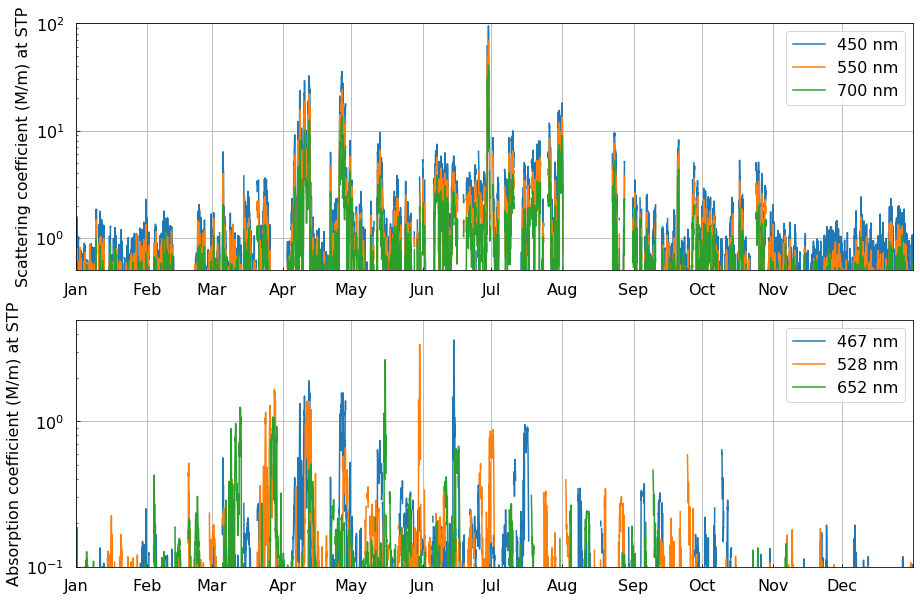

In [105]:
# Plot qc'd

sc_qcd = sc_df.copy()
sc_qcd[sc_df['QC']!=1]=np.nan

ab_qcd = ab_df.copy()
ab_qcd[ab_df['QC']!=1]=np.nan


fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(211)
ax1.plot(sc_qcd.index,sc_qcd['sc_1'],label='%s nm'%int(sc_wavelengths[0])) 
ax1.plot(sc_qcd.index,sc_qcd['sc_2'],label='%s nm'%int(sc_wavelengths[1])) 
ax1.plot(sc_qcd.index,sc_qcd['sc_3'],label='%s nm'%int(sc_wavelengths[2]))
ax1.set_ylabel('Scattering coefficient (M/m) at STP')
ax1.xaxis.set_major_formatter(md.DateFormatter('%H'))
ax1.xaxis.set_major_locator(md.HourLocator(interval=1))
ax1.set_ylim(0.5,100)
ax1.set_yscale('log')
ax1.set_xlim(start,stop)
ax1.grid('on')
ax1.legend()

ax1.xaxis.set_major_formatter(md.DateFormatter('%b'))
ax1.xaxis.set_major_locator(md.DayLocator(bymonthday=1))
#ax1.xaxis.set_major_locator(md.HourLocator(interval=3))


ax2 = fig.add_subplot(212)
ax2.plot(ab_qcd.index,ab_qcd['ab_1'],label='%s nm'%int(ab_wavelengths[0])) 
ax2.plot(ab_qcd.index,ab_qcd['ab_2'],label='%s nm'%int(ab_wavelengths[1])) 
ax2.plot(ab_qcd.index,ab_qcd['ab_3'],label='%s nm'%int(ab_wavelengths[2]))
ax2.set_ylabel('Absorption coefficient (M/m) at STP')
ax2.xaxis.set_major_formatter(md.DateFormatter('%H'))
ax2.xaxis.set_major_locator(md.HourLocator(interval=1))
ax2.set_ylim(0.1,5)
ax2.set_yscale('log')
ax2.set_xlim(start,stop)
ax2.grid('on')
ax2.legend()

ax2.xaxis.set_major_formatter(md.DateFormatter('%b'))
ax2.xaxis.set_major_locator(md.DayLocator(bymonthday=1))
#ax1.xaxis.set_major_locator(md.HourLocator(interval=3))

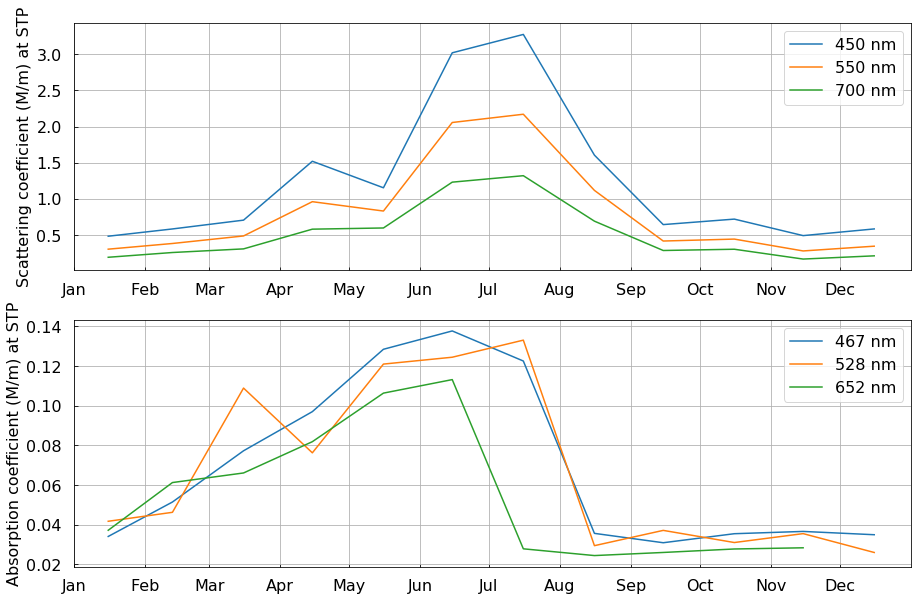

In [109]:

monthly_med_sc = sc_qcd.resample('1M').median()
monthly_med_ab = ab_qcd.resample('1M').median()
months = monthly_med_ab.index - pd.Timedelta(days=15)

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(211)
ax1.plot(months,monthly_med_sc['sc_1'],label='%s nm'%int(sc_wavelengths[0])) 
ax1.plot(months,monthly_med_sc['sc_2'],label='%s nm'%int(sc_wavelengths[1])) 
ax1.plot(months,monthly_med_sc['sc_3'],label='%s nm'%int(sc_wavelengths[2]))
ax1.set_ylabel('Scattering coefficient (M/m) at STP')
ax1.xaxis.set_major_formatter(md.DateFormatter('%H'))
ax1.xaxis.set_major_locator(md.HourLocator(interval=1))
#ax1.set_ylim(0.5,100)
#ax1.set_yscale('log')
ax1.set_xlim(start,stop)
ax1.grid('on')
ax1.legend()

ax1.xaxis.set_major_formatter(md.DateFormatter('%b'))
ax1.xaxis.set_major_locator(md.DayLocator(bymonthday=1))
#ax1.xaxis.set_major_locator(md.HourLocator(interval=3))


ax2 = fig.add_subplot(212)
ax2.plot(months,monthly_med_ab['ab_1'],label='%s nm'%int(ab_wavelengths[0])) 
ax2.plot(months,monthly_med_ab['ab_2'],label='%s nm'%int(ab_wavelengths[1])) 
ax2.plot(months,monthly_med_ab['ab_3'],label='%s nm'%int(ab_wavelengths[2]))
ax2.set_ylabel('Absorption coefficient (M/m) at STP')
ax2.xaxis.set_major_formatter(md.DateFormatter('%H'))
ax2.xaxis.set_major_locator(md.HourLocator(interval=1))
#ax2.set_ylim(0.1,5)
#ax2.set_yscale('log')
ax2.set_xlim(start,stop)
ax2.grid('on')
ax2.legend()

ax2.xaxis.set_major_formatter(md.DateFormatter('%b'))
ax2.xaxis.set_major_locator(md.DayLocator(bymonthday=1))
#ax1.xaxis.set_major_locator(md.HourLocator(interval=3))

In [110]:
# Single-scattering albedo (SSA)
# The ratio of scattering to extinction, indicative of aerosol darkness
# White aerosols (i.e. sea salt) have higher SSA
# Dark aerosols (i.e. black carbon) have lower SSA values. 
# a value of unity implies that all particle extinction is due to scattering; 
# conversely, a single-scattering albedo of zero implies that all extinction is due to absorption.

# SSA = sc / (sc + ab)
# Using 550 nm as in Schmeisser et al 2018)

SSA = sc_qcd['sc_2'] / (sc_qcd['sc_2'] + ab_qcd['ab_2'])

# Plot monthly medians
SSA_df = pd.DataFrame({'Time':time,'SSA':SSA})
SSA_df = SSA_df.set_index('Time')
SSA_df.index = pd.DatetimeIndex(SSA_df.index)

monthly_med_SSA = SSA_df.resample('1M').median()


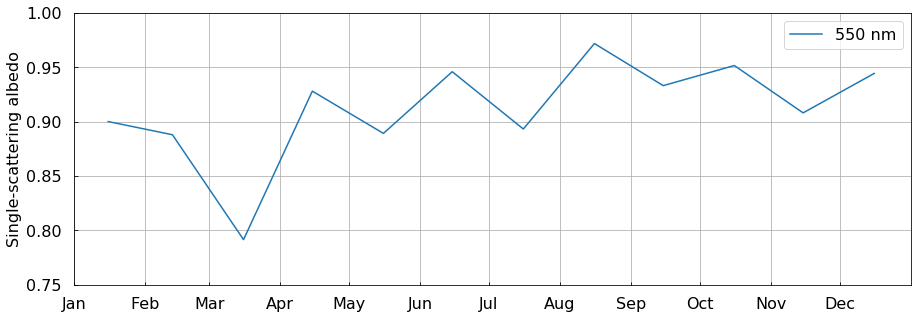

In [111]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(111)
ax1.plot(months,monthly_med_SSA,label='550 nm') 
#ax1.plot(time,sc_coef[1,:],label='%s nm'%int(sc_wavelengths[1])) 
#ax1.plot(time,sc_coef[2,:],label='%s nm'%int(sc_wavelengths[2]))
ax1.set_ylabel('Single-scattering albedo')
ax1.xaxis.set_major_formatter(md.DateFormatter('%H'))
ax1.xaxis.set_major_locator(md.HourLocator(interval=1))
ax1.set_ylim(0.75,1)
#ax1.set_yscale('log')
ax1.set_xlim(start,stop)
ax1.grid('on')
ax1.legend()

ax1.xaxis.set_major_formatter(md.DateFormatter('%b'))
ax1.xaxis.set_major_locator(md.DayLocator(bymonthday=1))
#ax1.xaxis.set_major_locator(md.HourLocator(interval=3))